In [30]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
class EmotionDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [32]:
class EmotionLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.3):
        super(EmotionLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.dropout1 = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim, 64)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, output_dim)
    
    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)
        # Get the output from the last time step
        lstm_out = lstm_out[:, -1, :]
        # Dropout
        x = self.dropout1(lstm_out)
        # Dense layer with ReLU
        x = self.relu(self.fc1(x))
        # Dropout
        x = self.dropout2(x)
        # Output layer (no activation as CrossEntropyLoss includes softmax)
        x = self.fc2(x)
        return x

In [33]:
def load_ravdess_data():
    """Load and preprocess the RAVDESS dataset"""
    emotion_files = {
        'neutral': "C:/Nini/Capstone/CSV_Files/Neutral.xlsx",
        'calm': "C:/Nini/Capstone/CSV_Files/Calm.xlsx",
        'happy': "C:/Nini/Capstone/CSV_Files/Happy 1.xlsx",
        'sad': "C:/Nini/Capstone/CSV_Files/Sad.xlsx",
        'angry': "C:/Nini/Capstone/CSV_Files/Angry.xlsx",
        'fearful': "C:/Nini/Capstone/CSV_Files/Fearful.xlsx",
        'disgust': "C:/Nini/Capstone/CSV_Files/Disgusted.xlsx",
        'surprised': "C:/Nini/Capstone/CSV_Files/Surprised.xlsx"
    }
    
    all_data = []
    
    for emotion, file_path in emotion_files.items():
        try:
            df = pd.read_excel(file_path)
            df['emotion'] = emotion
            all_data.append(df)
            print(f"Loaded {emotion} data: {len(df)} samples")
        except Exception as e:
            print(f"Error loading {emotion} file: {str(e)}")
    
    combined_df = pd.concat(all_data, ignore_index=True)
    
    feature_columns = [
        'face_x', 'face_y', 'face_width', 'face_height', 'face_aspect_ratio',
        'left_eye_x', 'left_eye_y', 'left_eye_width', 'left_eye_height',
        'right_eye_x', 'right_eye_y', 'right_eye_width', 'right_eye_height',
        'eye_separation', 'mouth_x', 'mouth_y', 'mouth_width', 'mouth_height',
        'mouth_aspect_ratio', 'avg_intensity', 'intensity_variance'
    ]
    
    print("\nDataset Statistics:")
    print(f"Total samples: {len(combined_df)}")
    print("\nSamples per emotion:")
    print(combined_df['emotion'].value_counts())
    
    X = combined_df[feature_columns].values
    
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(combined_df['emotion'])
    
    return X, y, label_encoder

In [34]:
class EmotionDetectionPyTorch:
    def __init__(self, X, y, label_encoder):
        # Split the data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y)
        
        # Standardize features
        self.scaler = StandardScaler()
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)
        
        # Reshape for LSTM (samples, sequence_length, features)
        self.X_train_reshaped = self.X_train_scaled.reshape(
            (self.X_train_scaled.shape[0], 1, self.X_train_scaled.shape[1]))
        self.X_test_reshaped = self.X_test_scaled.reshape(
            (self.X_test_scaled.shape[0], 1, self.X_test_scaled.shape[1]))
        
        self.label_encoder = label_encoder
        self.num_classes = len(label_encoder.classes_)
        
        # Set device
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        # Create datasets and dataloaders
        self.train_dataset = EmotionDataset(self.X_train_reshaped, self.y_train)
        self.test_dataset = EmotionDataset(self.X_test_reshaped, self.y_test)
        
        self.results = {}
        
        print(f"\nTraining set shape: {self.X_train.shape}")
        print(f"Testing set shape: {self.X_test.shape}")

    def create_dataloaders(self, batch_size=32):
        """Create DataLoaders for train and test sets"""
        train_loader = DataLoader(
            self.train_dataset, 
            batch_size=batch_size, 
            shuffle=True
        )
        
        test_loader = DataLoader(
            self.test_dataset,
            batch_size=batch_size,
            shuffle=False
        )
        
        return train_loader, test_loader
    
    def create_lstm_model(self):
        """Create LSTM model"""
        input_dim = self.X_train.shape[1]  # Number of features
        hidden_dim = 128
        model = EmotionLSTM(input_dim, hidden_dim, self.num_classes)
        model.to(self.device)
        return model
    
    def train_model(self, model, train_loader, test_loader, epochs=1000, learning_rate=0.001):
        """Train the PyTorch model"""
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        # For tracking metrics
        train_losses = []
        train_accs = []
        val_losses = []
        val_accs = []
        
        print(f"\nTraining LSTM model...")
        for epoch in range(epochs):
            # Training phase
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Backward pass and optimize
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                
                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_acc = correct / total
            train_losses.append(epoch_loss)
            train_accs.append(epoch_acc)
            
            # Validation phase
            model.eval()
            val_running_loss = 0.0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    val_running_loss += loss.item() * inputs.size(0)
                    
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
            
            val_epoch_loss = val_running_loss / len(test_loader.dataset)
            val_epoch_acc = val_correct / val_total
            val_losses.append(val_epoch_loss)
            val_accs.append(val_epoch_acc)
            
            # Print statistics
            if (epoch + 1) % 5 == 0 or epoch == 0:
                print(f"Epoch {epoch+1}/{epochs} - "
                      f"Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f} - "
                      f"Val Loss: {val_epoch_loss:.4f} - Val Acc: {val_epoch_acc:.4f}")
        
        history = {
            'loss': train_losses,
            'accuracy': train_accs,
            'val_loss': val_losses,
            'val_accuracy': val_accs
        }
        
        return model, history
    
    def evaluate_model(self, model, test_loader):
        """Evaluate the model on test data"""
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Convert indices to emotion labels
        pred_emotions = self.label_encoder.inverse_transform(all_preds)
        true_emotions = self.label_encoder.inverse_transform(all_labels)
        
        # Calculate metrics
        conf_matrix = confusion_matrix(true_emotions, pred_emotions)
        class_report = classification_report(true_emotions, pred_emotions)
        
        return conf_matrix, class_report, pred_emotions, true_emotions
    
    def plot_confusion_matrix(self, conf_matrix, title, emotion_labels):
        """Plot confusion matrix"""
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                   xticklabels=emotion_labels, yticklabels=emotion_labels)
        plt.title(title)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

    def plot_training_history(self, history, title):
        """Plot training history"""
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(history['accuracy'], label='Training Accuracy')
        plt.plot(history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'{title} - Accuracy')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history['loss'], label='Training Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.title(f'{title} - Loss')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

    def run_experiment(self, model_name="LSTM", batch_size=32, epochs=1000, learning_rate=0.001):
        """Run a complete experiment"""
        # Create dataloaders
        train_loader, test_loader = self.create_dataloaders(batch_size)
        
        # Create model
        model = self.create_lstm_model()
        
        # Train model
        trained_model, history = self.train_model(
            model, train_loader, test_loader, epochs, learning_rate
        )
        
        # Evaluate model
        conf_matrix, class_report, pred_emotions, true_emotions = self.evaluate_model(
            trained_model, test_loader
        )
        
        # Store results
        self.results[model_name] = {
            'model': trained_model,
            'history': history,
            'confusion_matrix': conf_matrix,
            'classification_report': class_report,
            'predictions': pred_emotions,
            'true_labels': true_emotions
        }
        
        # Plot results
        self.plot_training_history(history, model_name)
        self.plot_confusion_matrix(
            conf_matrix, f'{model_name} Confusion Matrix', 
            self.label_encoder.classes_
        )
        
        print(f"\n{model_name} Classification Report:")
        print(class_report)
        
        return trained_model
    
    def print_comparison(self):
        """Print comparison of different models"""
        print("\nModel Comparison Results")
        print("=" * 50)
        
        summary_data = []
        
        for model_name, result in self.results.items():
            print(f"\n{model_name} Results")
            print("-" * 30)
            print("\nClassification Report:")
            print(result['classification_report'])
            
            val_acc = result['history']['val_accuracy'][-1]
            val_loss = result['history']['val_loss'][-1]
            
            summary_data.append({
                'Model': model_name,
                'Validation Accuracy': val_acc,
                'Validation Loss': val_loss
            })
        
        summary_df = pd.DataFrame(summary_data)
        print("\nSummary of Results:")
        print(summary_df.to_string(index=False))

    def save_model(self, model, path='emotion_lstm_model.pth'):
        """Save the PyTorch model"""
        torch.save(model.state_dict(), path)
        print(f"Model saved to {path}")

    def load_model(self, path='emotion_lstm_model.pth'):
        """Load a saved PyTorch model"""
        model = self.create_lstm_model()
        model.load_state_dict(torch.load(path, map_location=self.device))
        model.eval()
        return model

Loaded neutral data: 10036 samples
Loaded calm data: 21777 samples
Loaded happy data: 20865 samples
Loaded sad data: 21188 samples
Loaded angry data: 22208 samples
Loaded fearful data: 20499 samples
Loaded disgust data: 22611 samples
Loaded surprised data: 20006 samples

Dataset Statistics:
Total samples: 159190

Samples per emotion:
emotion
disgust      22611
angry        22208
calm         21777
sad          21188
happy        20865
fearful      20499
surprised    20006
neutral      10036
Name: count, dtype: int64
Using device: cuda:0

Training set shape: (127352, 21)
Testing set shape: (31838, 21)

Training LSTM model...
Epoch 1/50 - Loss: 1.6941 - Acc: 0.3506 - Val Loss: 1.5067 - Val Acc: 0.4365
Epoch 5/50 - Loss: 1.2661 - Acc: 0.5350 - Val Loss: 1.0936 - Val Acc: 0.6197
Epoch 10/50 - Loss: 1.1389 - Acc: 0.5850 - Val Loss: 0.9431 - Val Acc: 0.6746
Epoch 15/50 - Loss: 1.0811 - Acc: 0.6066 - Val Loss: 0.8776 - Val Acc: 0.7005
Epoch 20/50 - Loss: 1.0447 - Acc: 0.6210 - Val Loss: 0.834

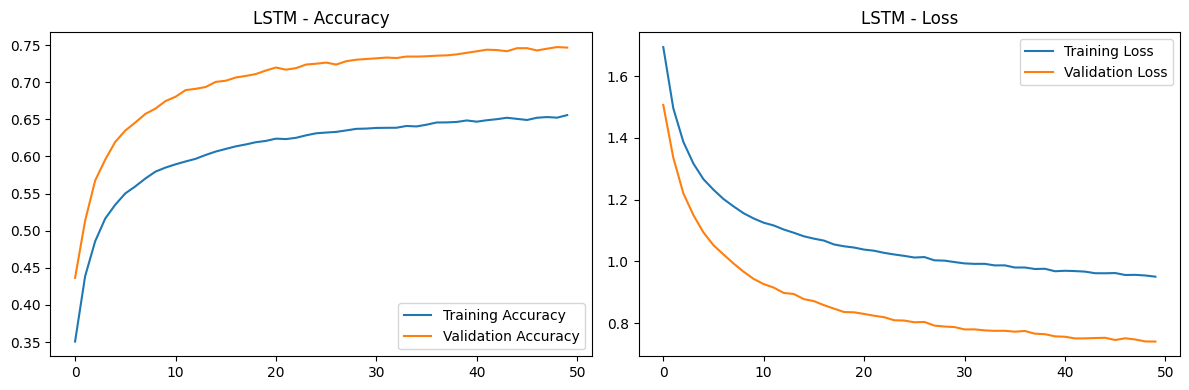

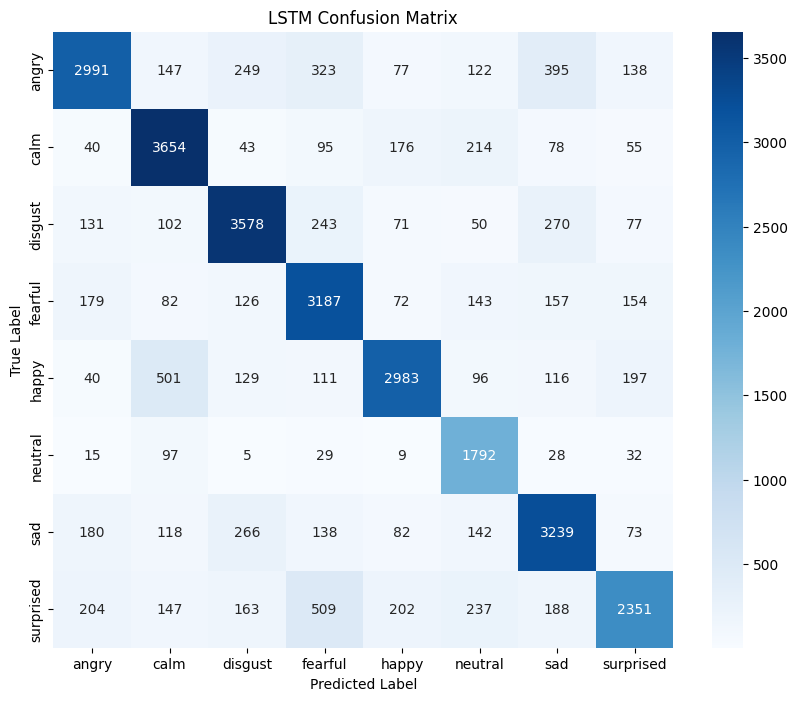


LSTM Classification Report:
              precision    recall  f1-score   support

       angry       0.79      0.67      0.73      4442
        calm       0.75      0.84      0.79      4355
     disgust       0.78      0.79      0.79      4522
     fearful       0.69      0.78      0.73      4100
       happy       0.81      0.71      0.76      4173
     neutral       0.64      0.89      0.75      2007
         sad       0.72      0.76      0.74      4238
   surprised       0.76      0.59      0.66      4001

    accuracy                           0.75     31838
   macro avg       0.74      0.76      0.74     31838
weighted avg       0.75      0.75      0.75     31838

Model saved to emotion_lstm_model.pth

Model Comparison Results

LSTM Results
------------------------------

Classification Report:
              precision    recall  f1-score   support

       angry       0.79      0.67      0.73      4442
        calm       0.75      0.84      0.79      4355
     disgust       0.78 

In [35]:
if __name__ == "__main__":
    # Load data
    X, y, label_encoder = load_ravdess_data()
    
    # Create model manager
    emotion_detector = EmotionDetectionPyTorch(X, y, label_encoder)
    
    # Run experiment
    model = emotion_detector.run_experiment(epochs=50)  # Reduced epochs for demonstration
    
    # Save model
    emotion_detector.save_model(model)
    
    # Print comparison if multiple models are trained
    emotion_detector.print_comparison()

In [29]:
torch.cuda.is_available()

True